In [1]:
# based on MoAC project by Michał Sadowski

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PyMPDATA'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PyMPDATA.git
    %cd PyMPDATA
    !pip install -r requirements.txt

In [3]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PyMPDATA/PyMPDATA_examples/Williamson_and_Rasch_1989_as_in_Jaruga_et_al_2015_Fig_14
sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [4]:
from PyMPDATA import VectorField, ScalarField
from PyMPDATA import Options
from PyMPDATA import PeriodicBoundaryCondition, PolarBoundaryCondition
from PyMPDATA import Stepper, Solver
import numpy as np
import numba
import matplotlib.pyplot as plt
import matplotlib

In [5]:
options = Options(n_iters=1) #

In [6]:
nlon = 64 # original: 128
nlat = 32 # original: 64
nt = 5120/3 # original: 5120
dlmb = 2*np.pi / nlon
dphi = np.pi / nlat

r = 5/64*np.pi #  original: 7/64*n.pi
x0 = 3*np.pi / 2
y0 = 0

udt = 2*np.pi / nt
b = -np.pi / 2
h0 = 0

In [7]:
boundary_conditions = (PeriodicBoundaryCondition(), PolarBoundaryCondition((nlon, nlat), 0, 1))

In [8]:
@numba.njit()
def pdf(i, j):
    tmp = 2*(
        (np.cos(dphi * (j + 0.5) - np.pi / 2) * np.sin((dlmb * (i+.5) - x0) / 2))**2 +
        np.sin((dphi * (j + 0.5) - np.pi / 2 - y0) / 2)**2
    )
    return h0 + np.where(
        # if
        tmp - r**2 <= 0,
        # then
        1 - np.sqrt(tmp)/r,
        # else
        0.
    )

In [9]:
def ad_x(i, j):
    return dlmb * udt * (
        np.cos(b) * np.cos(j * dphi - np.pi / 2) + 
        np.sin(b) * np.sin(j * dphi - np.pi / 2) * np.cos((i+.5) * dlmb)
    )

In [10]:
def ad_y(i, j):
    return -dlmb * udt * np.sin(b) * np.sin(i * dlmb)* np.cos((j+.5) * dphi - np.pi / 2)

In [11]:
advector_x = np.array([[
    ad_x(i, j)
    for j in range(nlat)] for i in range(nlon+1)])

advector_y = np.array([[
    ad_y(i, j)
    for j in range(nlat+1)] for i in range(nlon)])

-0.000361000342908348 0.000361000342908348


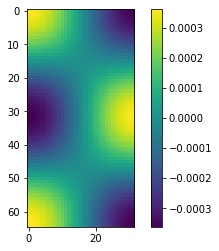

In [12]:
plt.imshow(advector_x)
plt.colorbar()
print(np.amin(advector_x), np.amax(advector_x))
np.testing.assert_array_almost_equal(advector_x[0,:], advector_x[-1,:])

-0.000361000342908348 0.000361000342908348


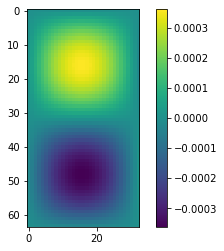

In [13]:
plt.imshow(advector_y)
plt.colorbar()
print(np.amin(advector_y), np.amax(advector_y))
np.testing.assert_array_almost_equal(advector_y[:,0], - advector_y[:,-1])

In [14]:
advector = VectorField(
    data=(advector_x, advector_y),
    halo=options.n_halo,
    boundary_conditions=boundary_conditions    
)

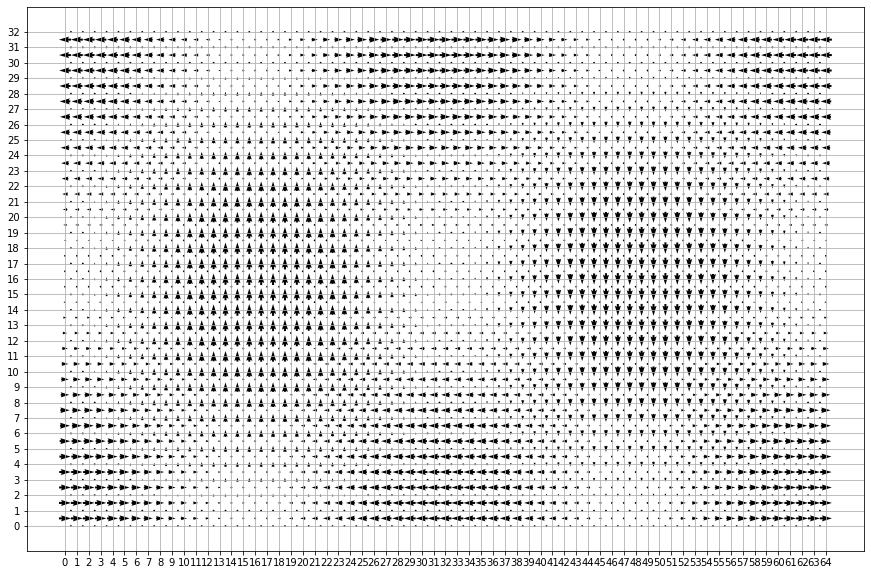

In [15]:
dx = 1
dy = 1
nx = nlon
ny = nlat

ux, uy = np.mgrid[
    0 : (nx+1)*dx : dx,
    dy/2 : ny*dy : dy
]

vx, vy = np.mgrid[
    dx/2 : nx*dx : dx,
    0: (ny+1)*dy : dy
]

fig = plt.figure(figsize=(15,10))
plt.xticks(ux[:,0])
plt.yticks(vy[0,:])
plt.grid()
plt.quiver(ux, uy, advector.get_component(0), 0, pivot='mid', scale=.025)
plt.quiver(vx, vy, 0, advector.get_component(1), pivot='mid', scale=.025)

In [16]:
@numba.njit()
def pdf_g_factor(x, y):
    return dlmb * dphi * np.cos(dphi * (y + .5) - np.pi / 2)
g_factor_z = np.array([[
    pdf_g_factor(i, j)
    for j in range(nlat)] for i in range(nlon)])

0.00047292825634092094


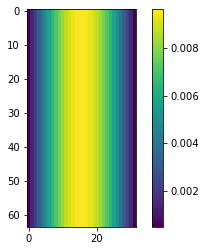

In [17]:
plt.imshow(g_factor_z)
plt.colorbar()
print(np.amin(np.abs(g_factor_z)))

In [18]:
Cx_max = np.amax(np.abs((advector_x[1:,:]+advector_x[:-1,:])/2/g_factor_z))
print(Cx_max)
assert Cx_max < 1

0.7633300359370178


In [19]:
Cy_max = np.amax(np.abs((advector_y[:,1:]+advector_y[:,:-1])/2/g_factor_z))
print(Cy_max)
assert Cy_max < 1

0.07481942725020725


In [20]:
g_factor = ScalarField(
    data=g_factor_z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [21]:
z = np.array([[
    pdf(i, j)
    for j in range(nlat)] for i in range(nlon)])

advectee = ScalarField(
    data=z, 
    halo=options.n_halo, 
    boundary_conditions=boundary_conditions
)

In [22]:
stepper = Stepper(options=options, n_dims=2, non_unit_g_factor=True)

/home/slayoo/devel/PyMPDATA/PyMPDATA_examples/Williamson_and_Rasch_1989_as_in_Jaruga_et_al_2015_Fig_14/../../PyMPDATA/stepper.py:47: UserWarning: Numba is using the ``workqueue'' threading layer, switch to ``omp'' or ``tbb'' for higher parallel performance (see https://numba.pydata.org/numba-doc/latest/user/threading-layer.html)
  warnings.warn("Numba is using the ``workqueue'' threading layer, switch"


In [23]:
solver = Solver(stepper=stepper, advectee=advectee, advector=advector, g_factor=g_factor)

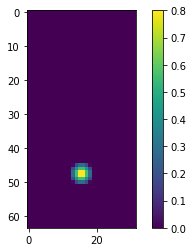

In [24]:
plt.imshow(solver.advectee.get())
plt.colorbar()

In [25]:
states_history = [z]
for i in range(64):
    solver.advance(nt=128)
    states_history.append(solver.advectee.get().copy())    

# Plots 

In [26]:
from matplotlib import cm
import matplotlib.animation as animation

theta = np.linspace(0, 1, nlat+1, endpoint=True) * np.pi
phi   = np.linspace(0, 1, nlon+1, endpoint=True) * 2 * np.pi

X = np.outer(np.sin(theta), np.cos(phi))
Y = np.outer(np.sin(theta), np.sin(phi))
Z = np.outer(np.cos(theta), np.ones(nlon+1))

def plot_state(state, save_path=None):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_axis_off()
    norm = matplotlib.colors.Normalize(vmin=h0, vmax=h0+.05) # TODO!
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                    facecolors=cm.bone_r(norm(state.T)), alpha=0.5, linewidth=.5)
    m = cm.ScalarMappable(cmap=cm.bone_r, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    if save_path:
        plt.savefig(save_path)
    return plt.show()

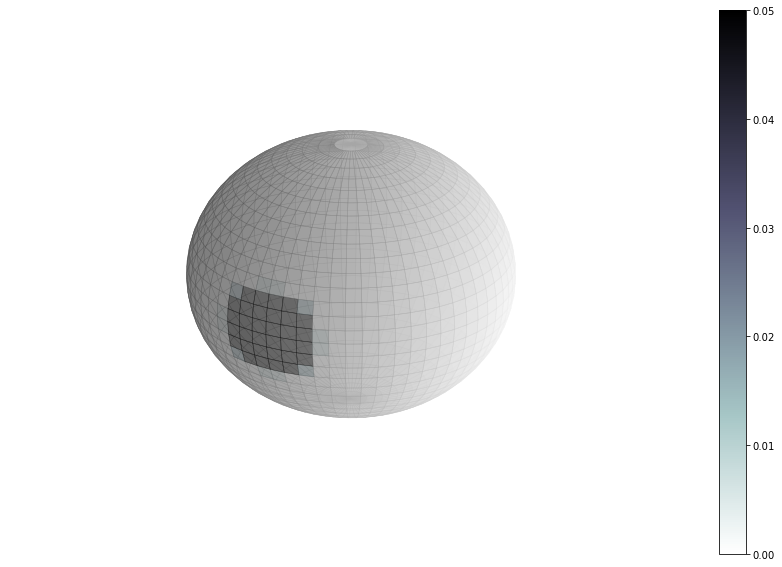

0.0 0.8001404851517866


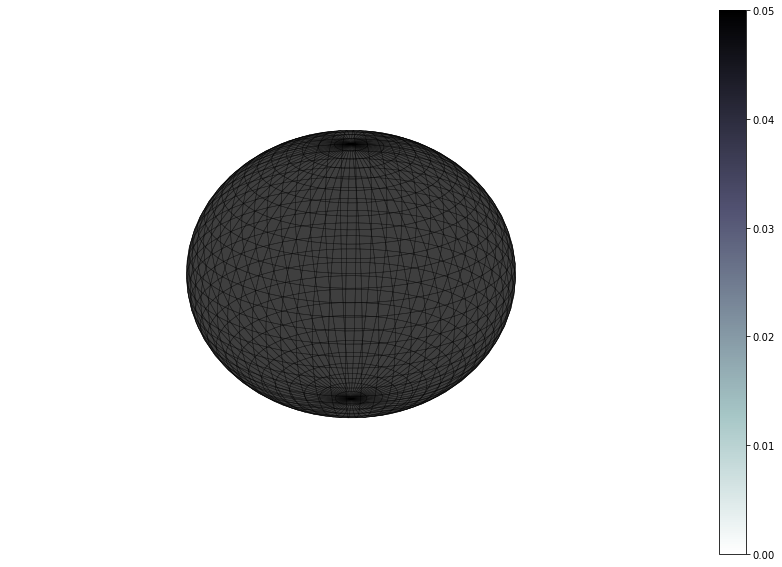

nan nan


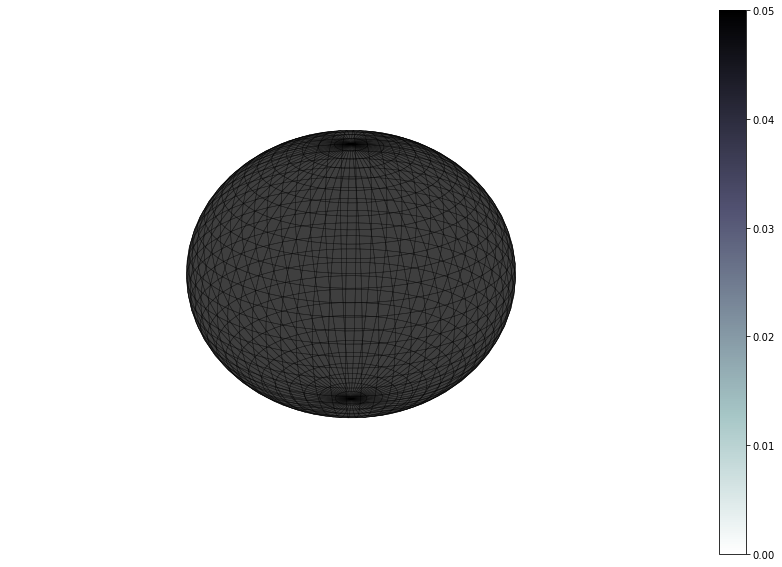

nan nan


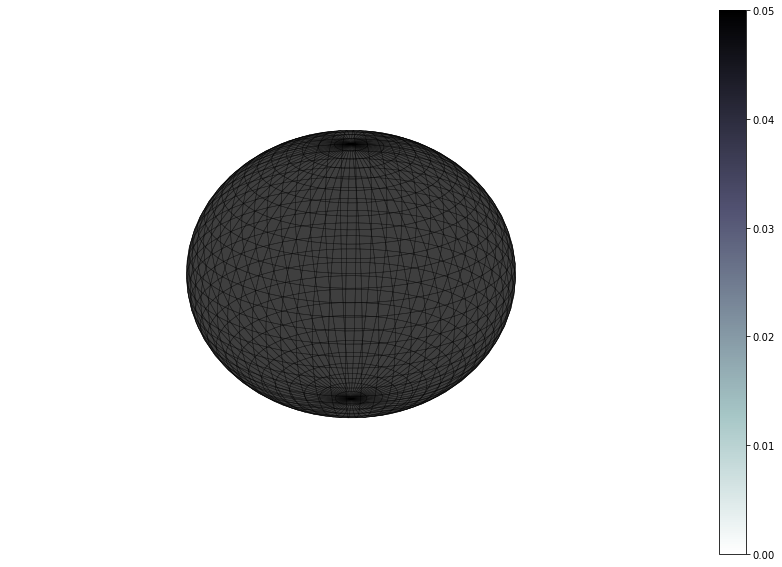

nan nan


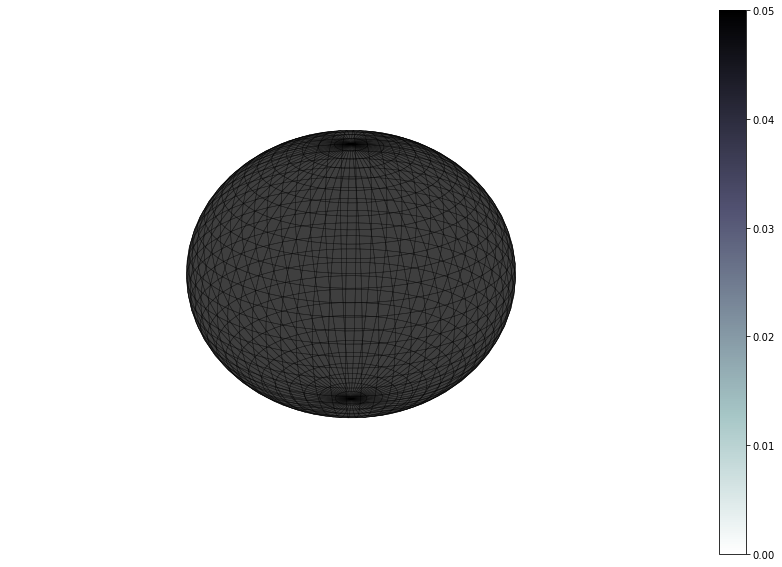

nan nan


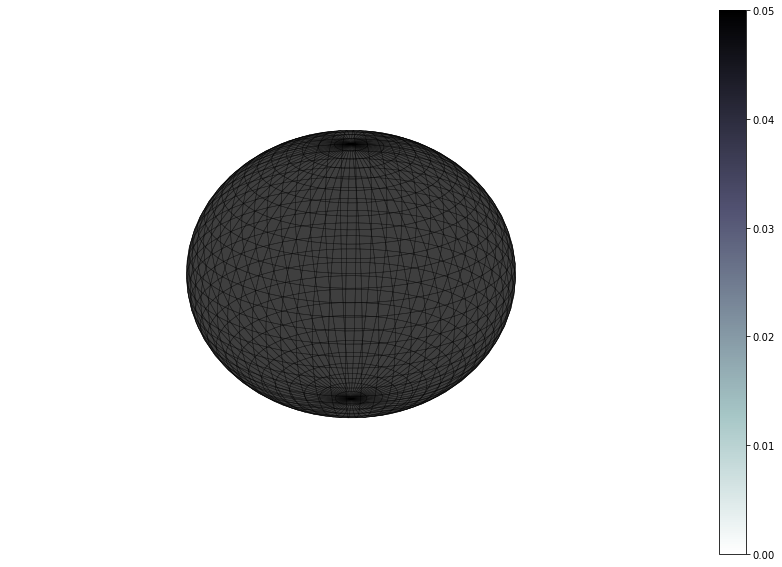

nan nan


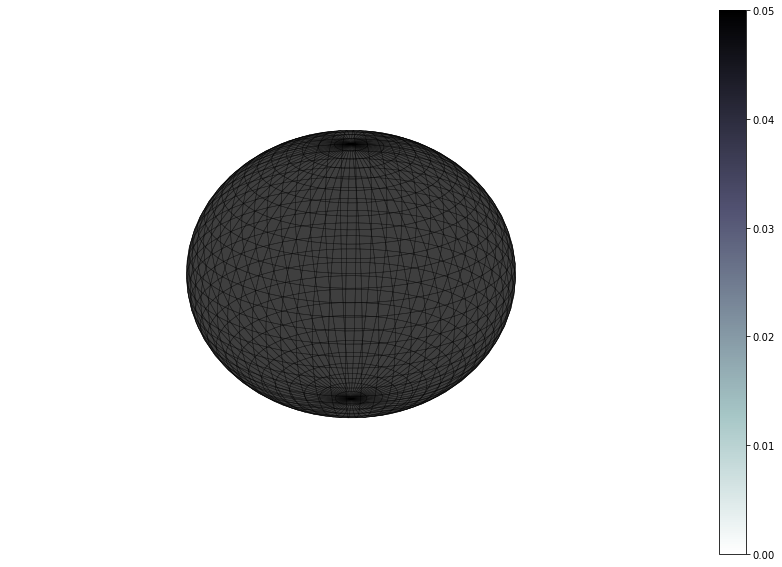

nan nan


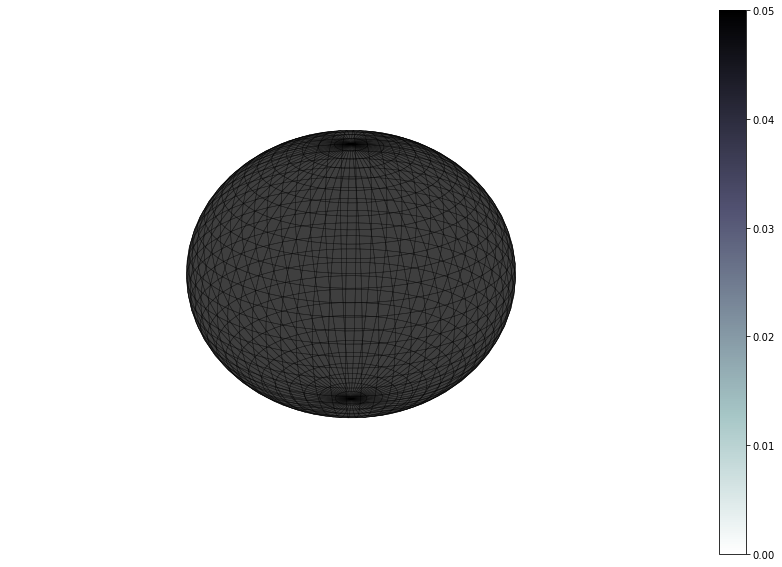

nan nan


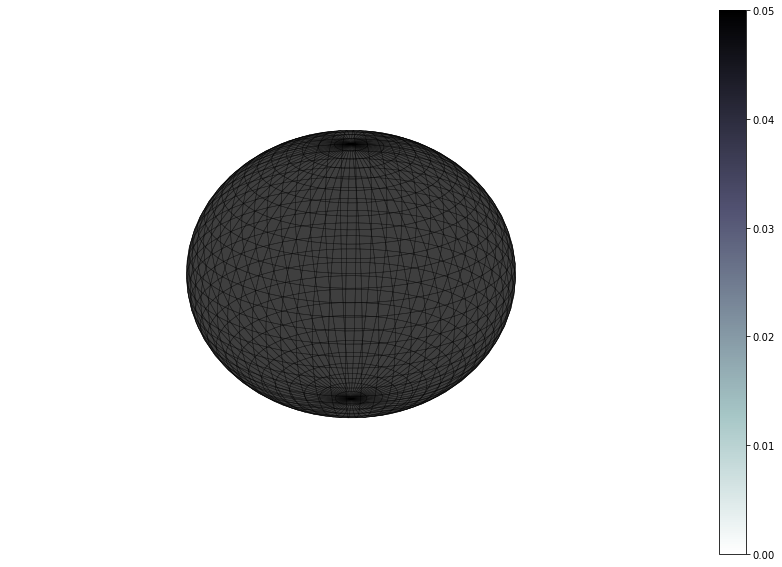

nan nan


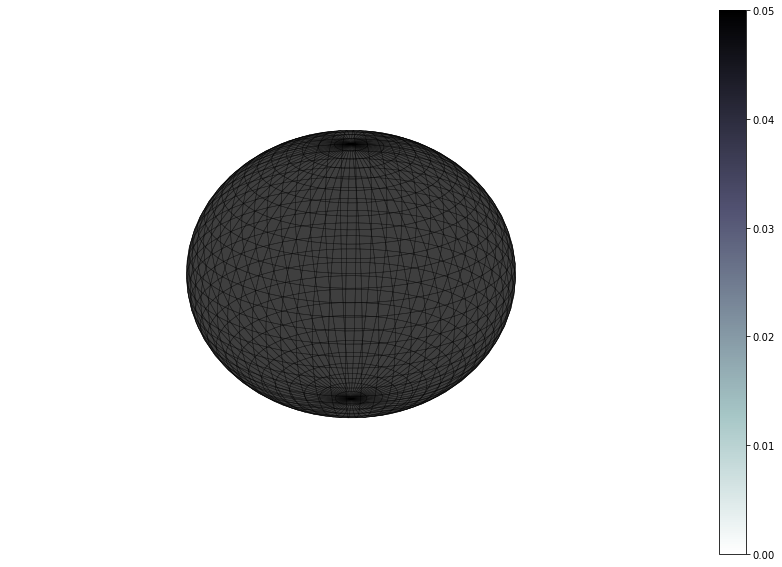

nan nan


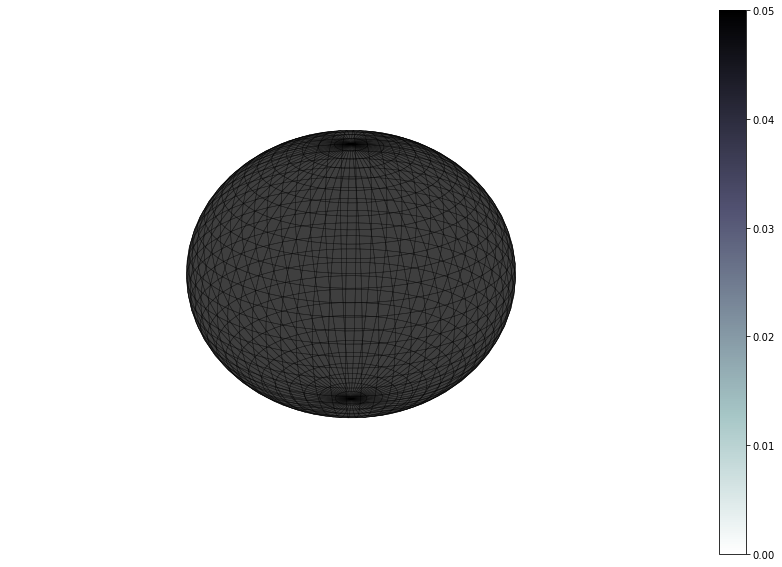

nan nan


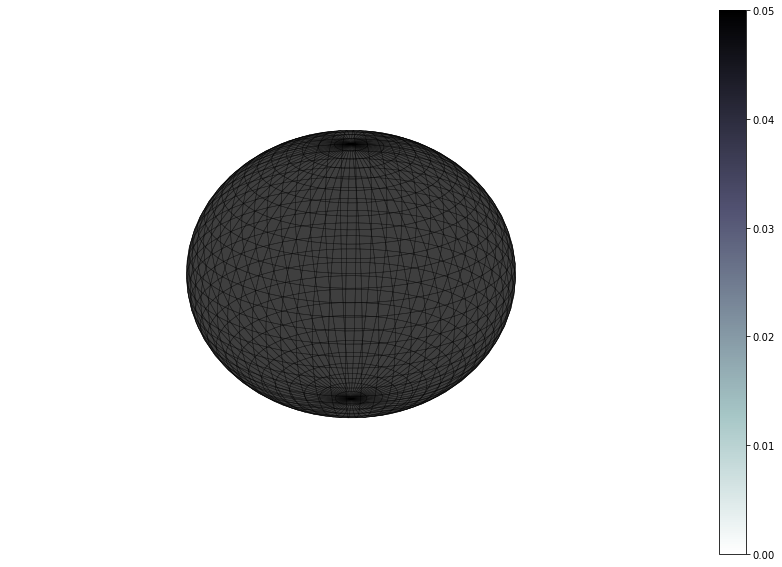

nan nan


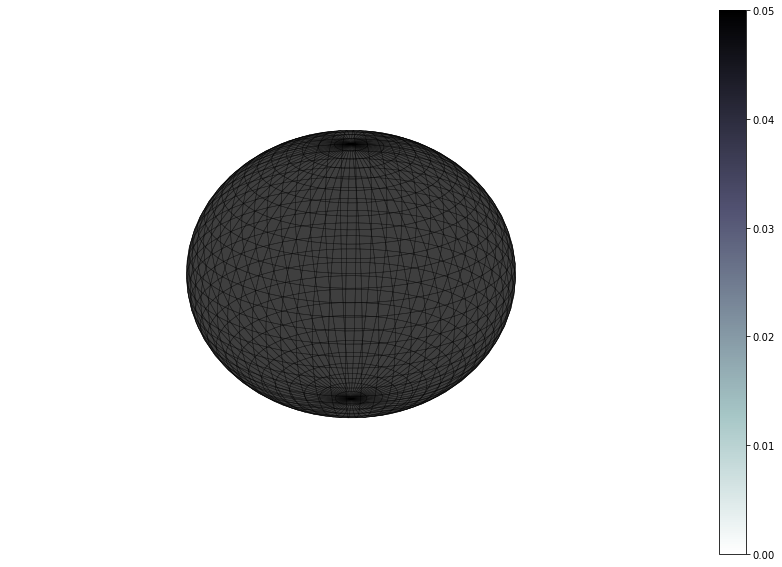

nan nan


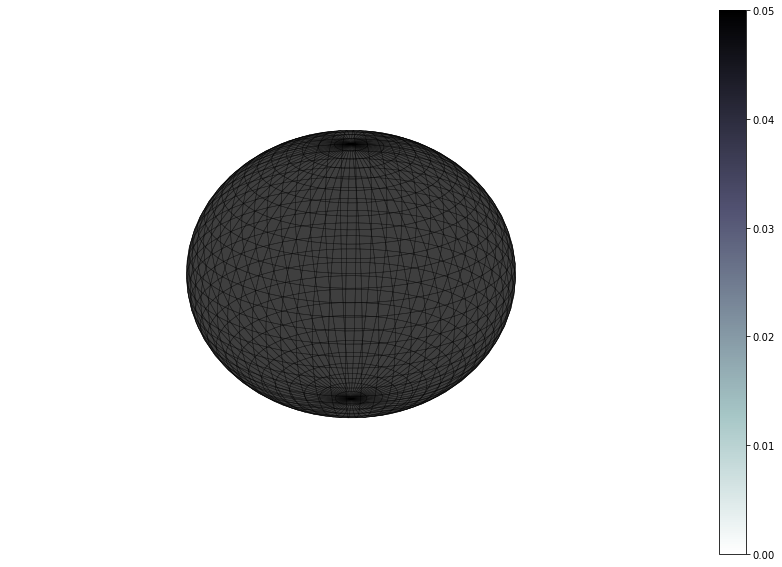

nan nan


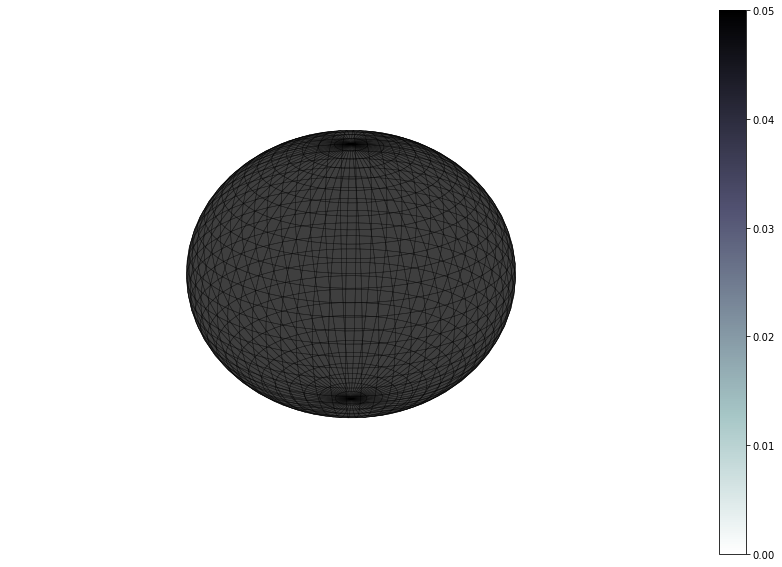

nan nan


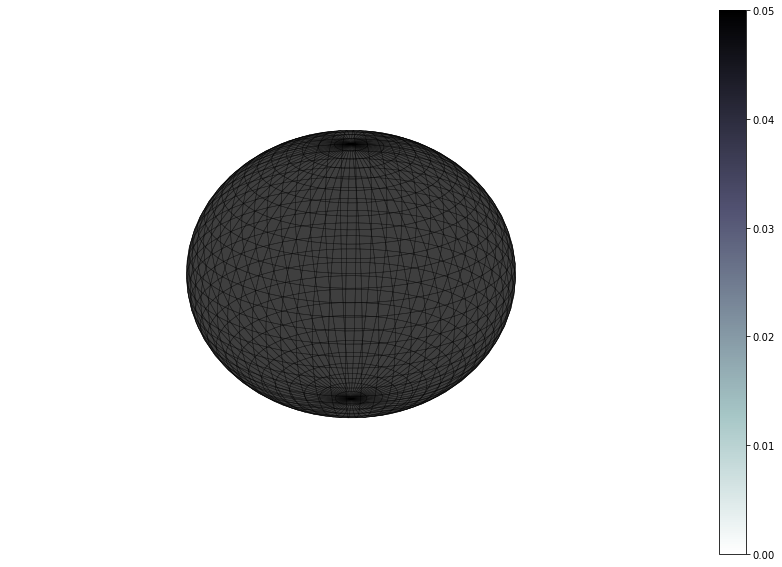

nan nan


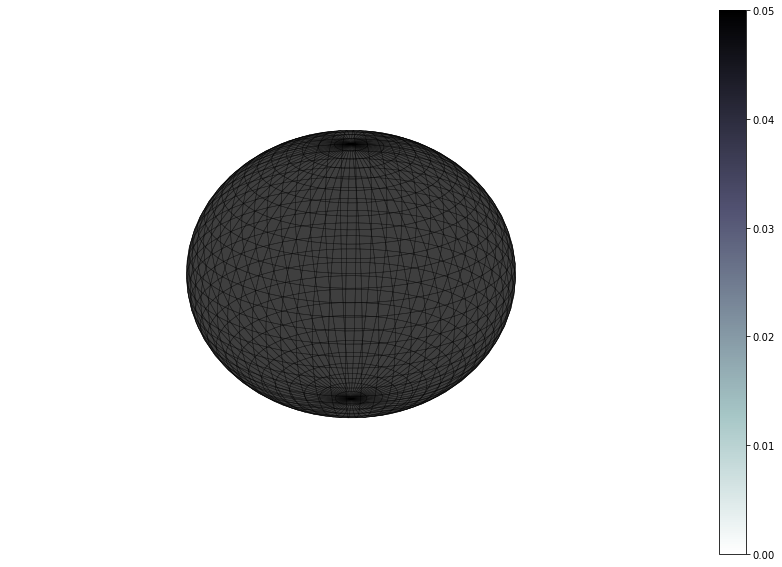

nan nan


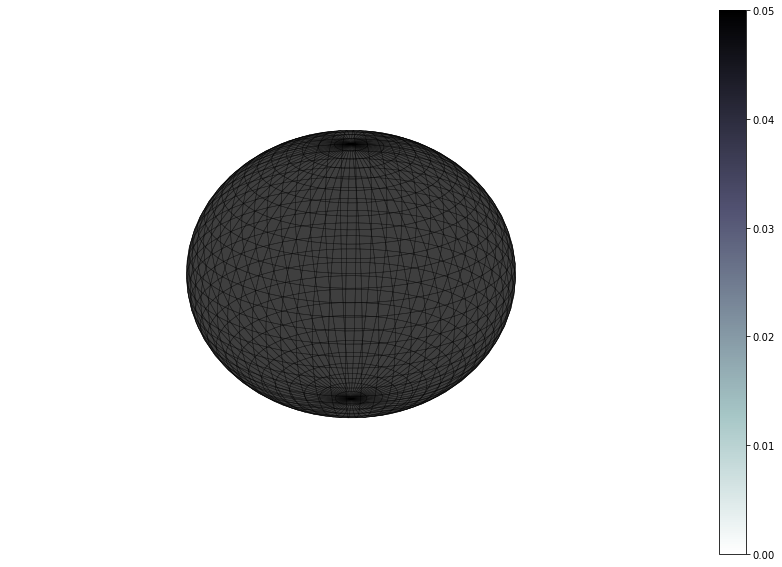

nan nan


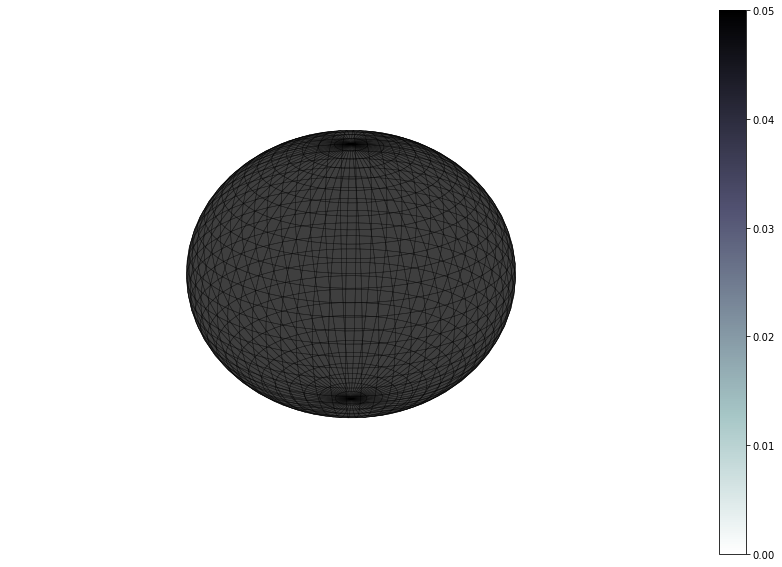

nan nan


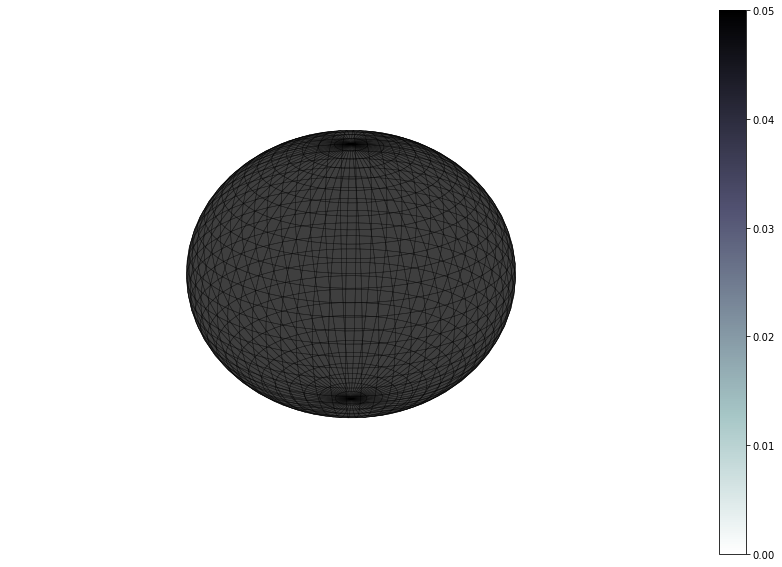

nan nan


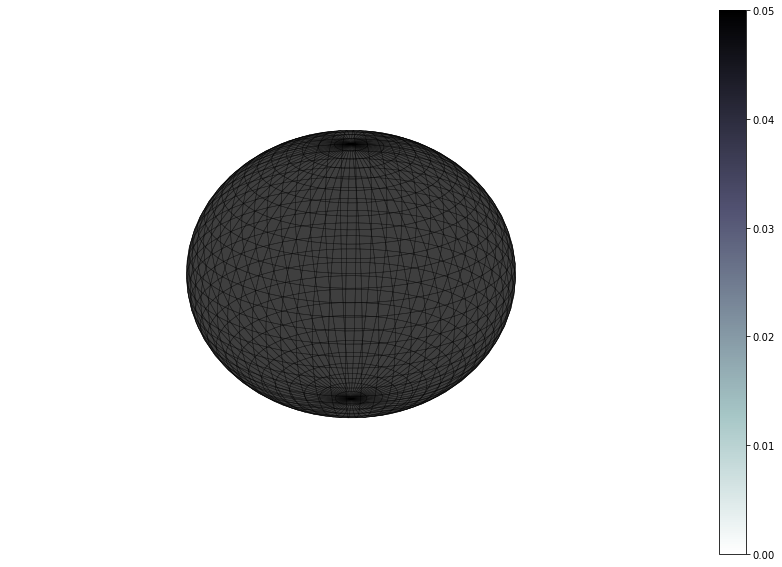

nan nan


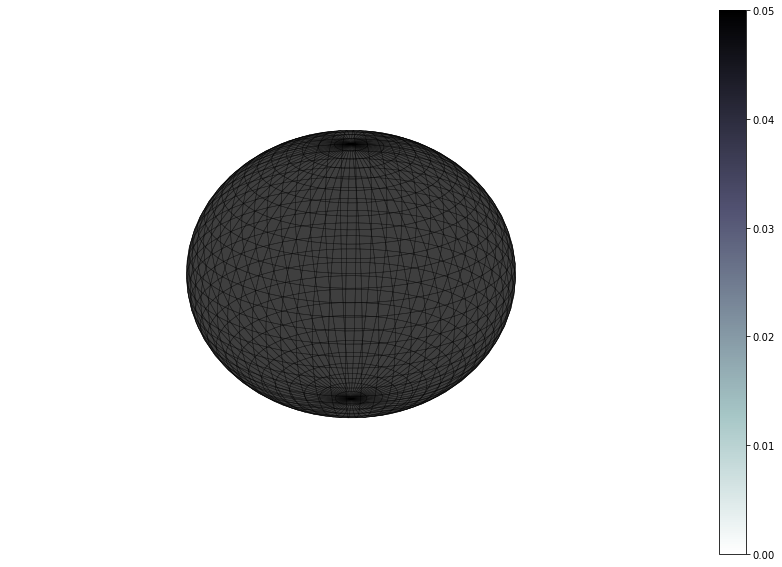

nan nan


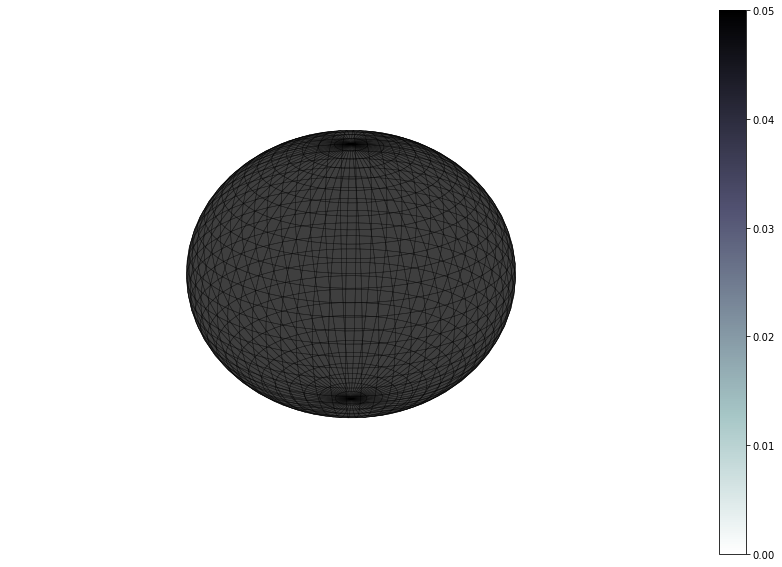

nan nan


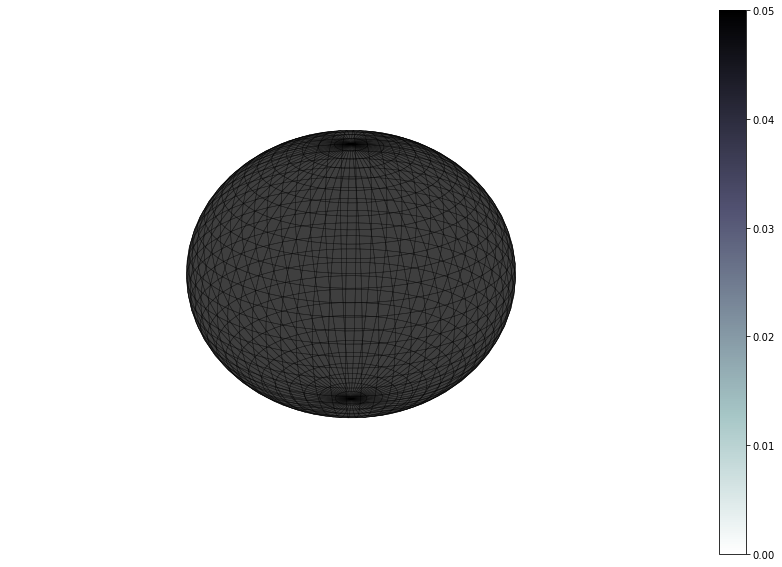

nan nan


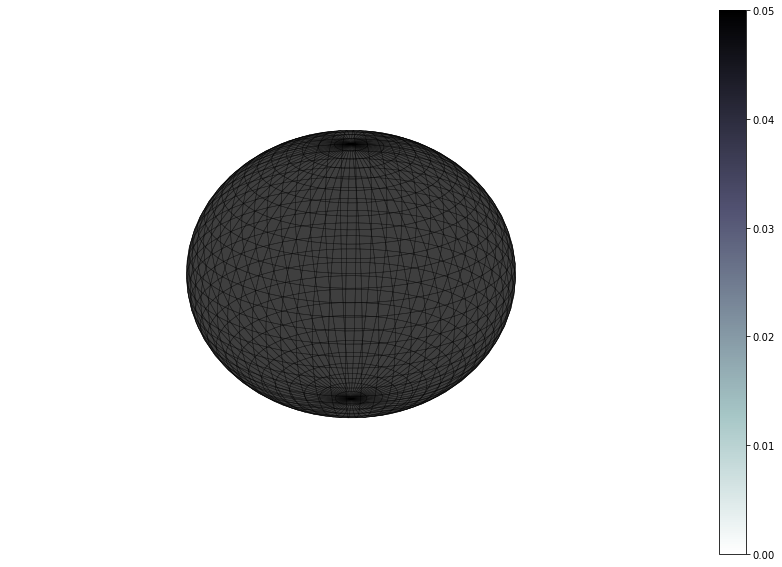

nan nan


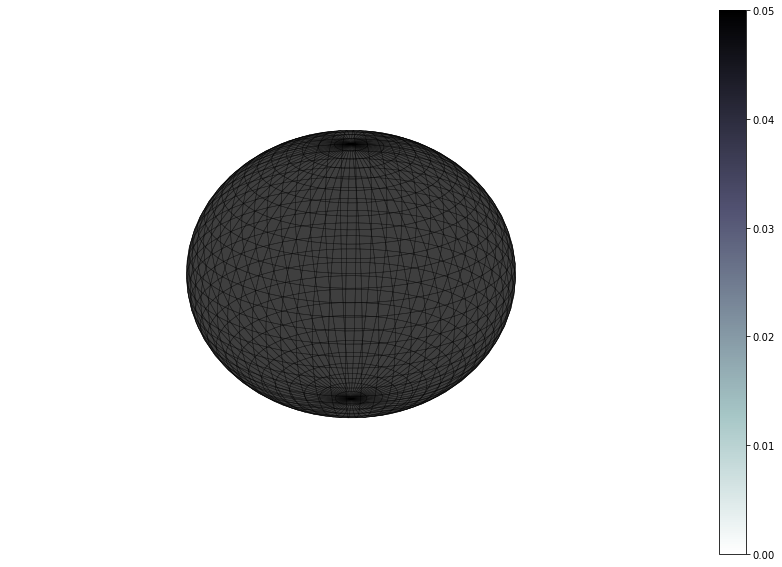

nan nan


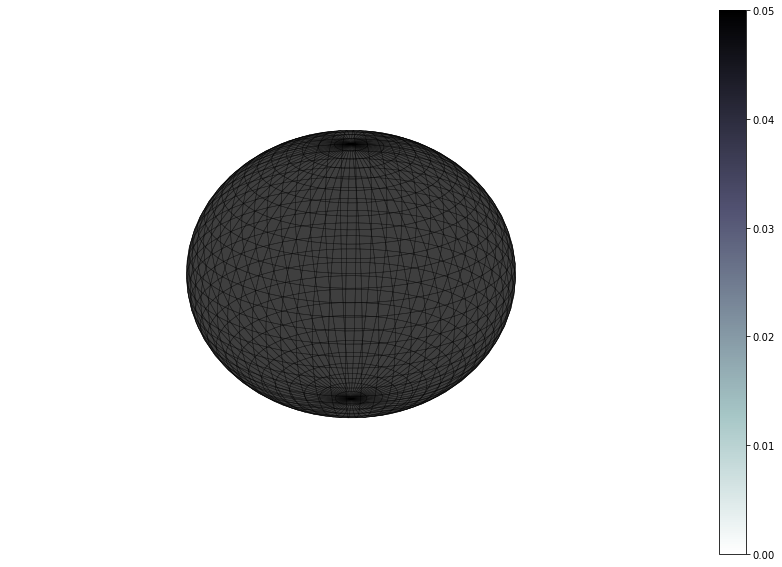

nan nan


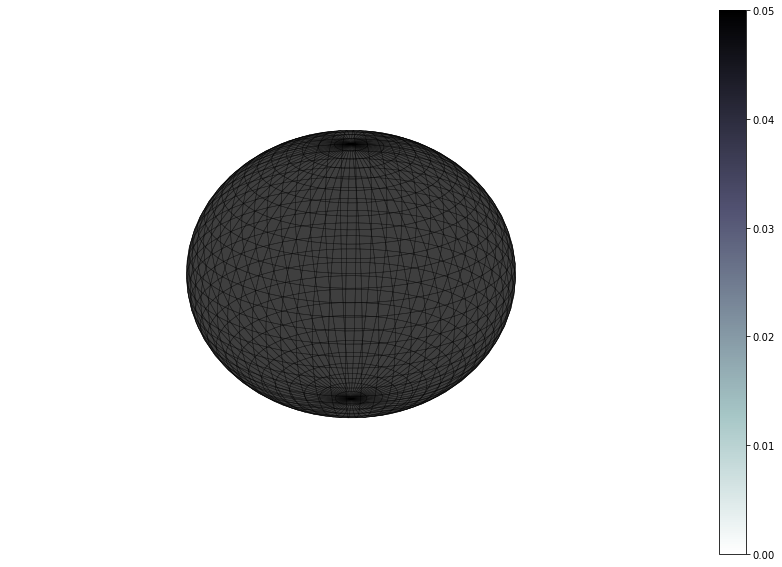

nan nan


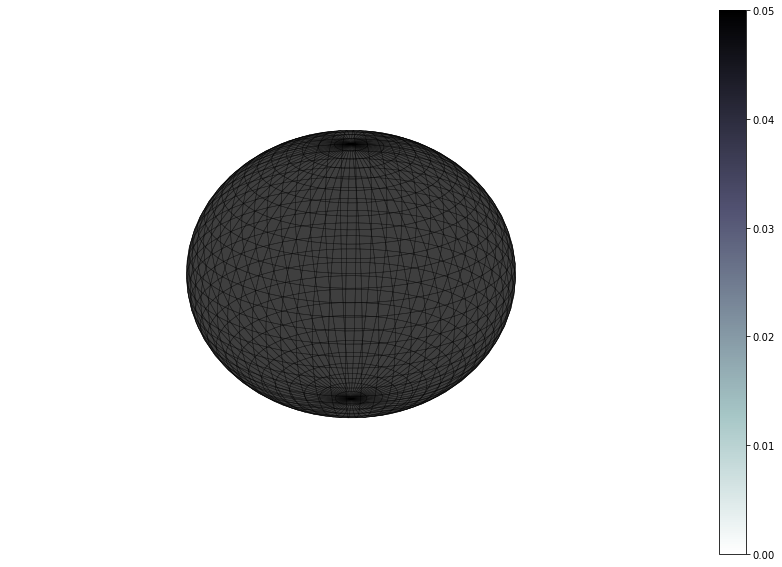

nan nan


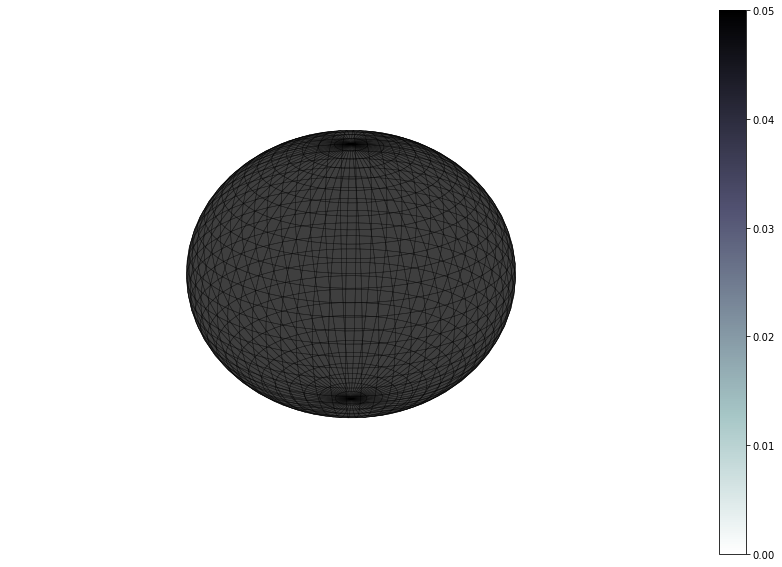

nan nan


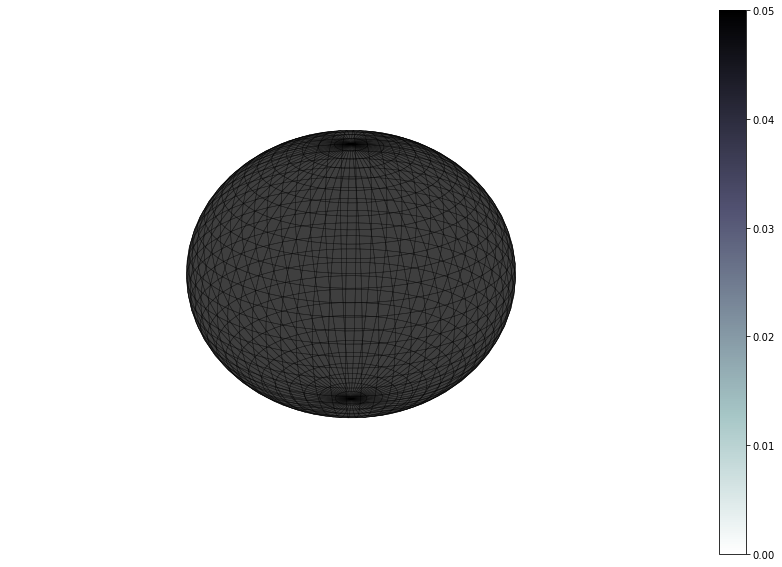

nan nan


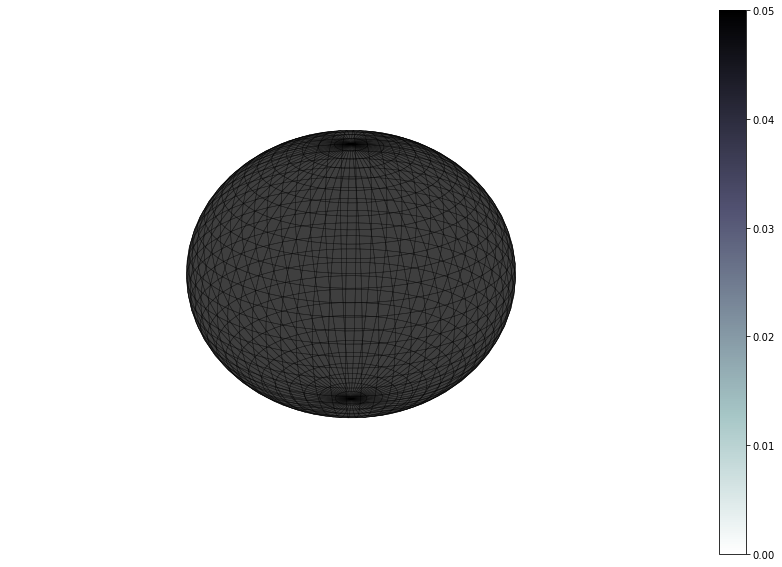

nan nan


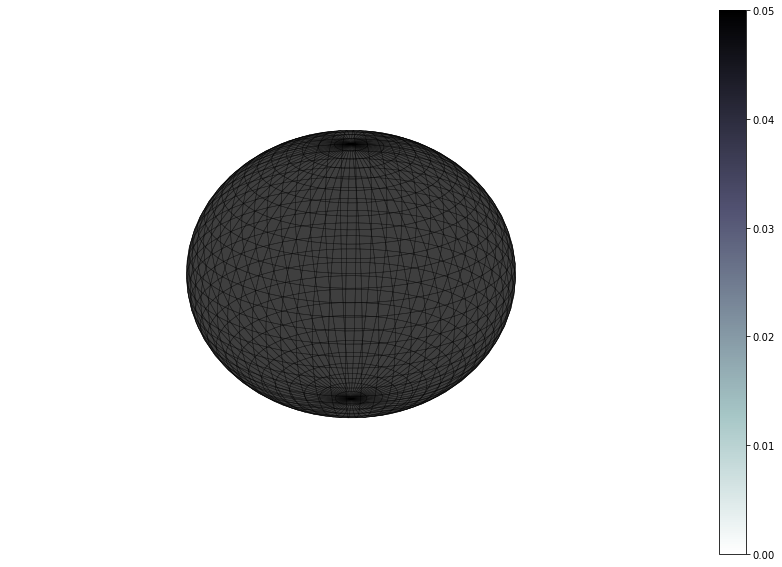

In [ ]:
!rm -rf animation
!mkdir animation
paths = []
for i, state in enumerate(states_history):
    path = 'animation/{}.png'.format(i)
    paths.append(path)
    plot_state(state, path)
    print(np.amin(state), np.amax(state))

In [ ]:
import os, shutil
if shutil.which('ffmpeg') is not None: os.system("ffmpeg -f image2 -r 10 -i ./animation/%01d.png -vcodec mpeg4 -y simulation.mp4")

In [ ]:
from IPython.display import Video
Video("simulation.mp4")